In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import pandas_profiling

import numpy as np

from math import *

from geopy.distance import geodesic 

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


import xgboost

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\AAZam\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


1. Загрузите датасет taxi.csv.
2. Отобразите общую информацию по признакам.
3. Выявите пропуски, а также возможные причины их возникновения. Решите, что следует сделать с ними. 
4. Оцените зависимости переменных между собой. Используйте корреляции и profile_report
5. Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей).
6. Найдите признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалите лишние, при необходимости.
7. Разделите выборку на обучаемую и тестовую.
8. Обучите модель. Напишите в markdown свои наблюдения по полученным результатам. 
Хорошие результаты дают классификаторы RandomForest и XGBoost

In [4]:
data = pd.read_csv('taxi.csv')
data.head()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
0   1105373            5        20       6080    174182        55.818842   
1    759733            5        14       6080    358774        55.805342   
2    416977            6        14       6080    866260        55.813978   
3    889660            2         6       6080    163522        55.745922   
4   1120055            4        16       6080    506710        55.803578   

   driver_longitude  origin_order_latitude  origin_order_longitude  \
0         37.334562              55.814567               37.355010   
1         37.515023              55.819329               37.466398   
2         37.347688              55.814827               37.354074   
3         37.421748              55.743469               37.431130   
4         37.521602              55.812559               37.527407   

   distance_km  duration_min offer_class_group ride_type_desc  driver_response  
0       -1.000        -1.000           Economy        private                0  
1       18.802        25.217          Standard        private                1  
2        6.747         9.800           Economy        private                0  
3       -1.000        -1.000           Economy        private                1  
4       12.383        19.250           Economy        private                1

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   offer_gk                100000 non-null  int64  
 1   weekday_key             100000 non-null  int64  
 2   hour_key                100000 non-null  int64  
 3   driver_gk               100000 non-null  int64  
 4   order_gk                100000 non-null  int64  
 5   driver_latitude         100000 non-null  float64
 6   driver_longitude        100000 non-null  float64
 7   origin_order_latitude   100000 non-null  float64
 8   origin_order_longitude  100000 non-null  float64
 9   distance_km             100000 non-null  float64
 10  duration_min            100000 non-null  float64
 11  offer_class_group       100000 non-null  object 
 12  ride_type_desc          100000 non-null  object 
 13  driver_response         100000 non-null  int64  
dtypes: float64(6), int64(

*Пропусков в данных нет, уже хорошо*

In [6]:
data.duplicated().sum()

0

In [7]:
data.isna().sum()

offer_gk                  0
weekday_key               0
hour_key                  0
driver_gk                 0
order_gk                  0
driver_latitude           0
driver_longitude          0
origin_order_latitude     0
origin_order_longitude    0
distance_km               0
duration_min              0
offer_class_group         0
ride_type_desc            0
driver_response           0
dtype: int64

**Проверили данные на дубликаты и пропуски другим методом. Всё ОК.**

## Поищем зависимости

##  Корреляции и зависимости между переменными

In [8]:
pandas_profiling.ProfileReport(data)

### Корреляция между координатами пассажира и водителя понятна, т.к. заказ предлагается ближайшему водителю. Сами по себе коорднаты не нужны, но с из помощью можно рассчитать расстояние от водителя до пассажира.

### Зависимость между дальностью поездки в километрах и продолжительностью движения в минутах объясняется средней скоростью движения. Подумаю - может стоить её использовать вместо времени и расстояния, т.к. они мультиколлениарны.

In [9]:
data.describe()

offer_gk    weekday_key       hour_key      driver_gk  \
count  1.000000e+05  100000.000000  100000.000000  100000.000000   
mean   5.662189e+05       3.159860      13.827790    3446.376360   
std    3.259360e+05       2.054222       7.306496    2038.738677   
min    4.000000e+00       0.000000       0.000000      14.000000   
25%    2.855552e+05       1.000000       8.000000    1421.000000   
50%    5.656715e+05       3.000000      16.000000    3506.500000   
75%    8.487198e+05       5.000000      20.000000    5242.000000   
max    1.130355e+06       6.000000      23.000000    6806.000000   

           order_gk  driver_latitude  driver_longitude  origin_order_latitude  \
count  100000.00000    100000.000000     100000.000000          100000.000000   
mean   460867.01291        55.700824         37.492292              55.772440   
std    266064.98953         2.135903          1.454640               0.665985   
min        18.00000        -1.000000         -1.000000              -1.000000   
25%    229178.50000        55.708651         37.413497              55.708032   
50%    462420.00000        55.772904         37.533664              55.772561   
75%    690894.00000        55.960667         37.624113              55.962000   
max    920344.00000        56.174097         38.280547              56.311121   

       origin_order_longitude    distance_km   duration_min  driver_response  
count           100000.000000  100000.000000  100000.000000    100000.000000  
mean                37.541637      18.393518      23.134841         0.492480  
std                  0.467758      41.129296      33.890105         0.499946  
min                 -1.000000      -1.000000      -1.000000         0.000000  
25%                 37.407117      -1.000000      -1.000000         0.000000  
50%                 37.532537      10.411500      19.700000         0.000000  
75%                 37.624358      30.665250      37.867000         1.000000  
max                 38.243608    5234.283000    3958.283000         1.000000

*Удалим столбец "offer_gk", т.к. все значения уникальны, это по сути это ID поездки. Также удалим столбец "order_gk", т.к. практического пользы от номера заказа нет*

In [10]:
data.drop(['offer_gk', 'order_gk'], axis = 1, inplace=True)
data.head()

weekday_key  hour_key  driver_gk  driver_latitude  driver_longitude  \
0            5        20       6080        55.818842         37.334562   
1            5        14       6080        55.805342         37.515023   
2            6        14       6080        55.813978         37.347688   
3            2         6       6080        55.745922         37.421748   
4            4        16       6080        55.803578         37.521602   

   origin_order_latitude  origin_order_longitude  distance_km  duration_min  \
0              55.814567               37.355010       -1.000        -1.000   
1              55.819329               37.466398       18.802        25.217   
2              55.814827               37.354074        6.747         9.800   
3              55.743469               37.431130       -1.000        -1.000   
4              55.812559               37.527407       12.383        19.250   

  offer_class_group ride_type_desc  driver_response  
0           Economy        private                0  
1          Standard        private                1  
2           Economy        private                0  
3           Economy        private                1  
4           Economy        private                1

##  Категориальные переменные

###  weekday_key  &  hour_key

посмотрим распределение наблюдений по дням недели и часам на предмет отсутствия очевидных провалов (отсутствия) наблюдений по отдельным сочетаниям признаков

In [11]:
pd.pivot_table(data,
               values     = ['driver_response'],
               index      = ['weekday_key'],
               columns    = ['hour_key'], 
               aggfunc    = ['count'])

count                                               ...  \
            driver_response                                               ...   
hour_key                 0    1    2    3    4    5    6    7    8    9   ...   
weekday_key                                                               ...   
0                      1167  648  547  440  482  410  272  163  200  233  ...   
1                      1610  608  388  249  479  302  261  428  603  478  ...   
2                       621  288  189  160  150  205  197  305  516  509  ...   
3                       527  332  165  110  134  138  147  383  520  482  ...   
4                       613  264  153  120  244  116  129  412  653  556  ...   
5                      1043  569  198  192  313  350  328  584  776  685  ...   
6                      1065  758  635  497  391  288  276  207  282  355  ...   

                                                                       
                                                                       
hour_key      14   15    16    17    18    19    20    21    22    23  
weekday_key                                                            
0            500  576   676   674   690   847   864  1060  1142  1353  
1            390  464   505   517   702   711   751   753   550   836  
2            477  581   605   707   849   822   936  1020   963  1004  
3            423  557   450   575   748   836   878   892   913   889  
4            445  585   585   612   854  1131   958  1163   959  1124  
5            733  884  1026  1169  1351  1259  1272  1231  1331  1633  
6            616  602   653   774   695   763   907  1279  1023  1345  

[7 rows x 24 columns]

In [12]:
pd.pivot_table(data, 
               values     = ['driver_response'],  
               index      = ['hour_key'],
               columns    = ['weekday_key'], 
               aggfunc    = ['mean'])

mean                                                    \
            driver_response                                                     
weekday_key               0         1         2         3         4         5   
hour_key                                                                        
0                  0.352185  0.125466  0.264090  0.356736  0.332790  0.242570   
1                  0.456790  0.217105  0.333333  0.361446  0.462121  0.289982   
2                  0.462523  0.252577  0.306878  0.430303  0.320261  0.424242   
3                  0.409091  0.188755  0.187500  0.436364  0.416667  0.380208   
4                  0.325726  0.144050  0.306667  0.335821  0.200820  0.182109   
5                  0.292683  0.218543  0.224390  0.304348  0.301724  0.222857   
6                  0.316176  0.356322  0.406091  0.523810  0.511628  0.350610   
7                  0.472393  0.600467  0.652459  0.582245  0.502427  0.508562   
8                  0.470000  0.587065  0.684109  0.621154  0.601838  0.527062   
9                  0.669528  0.702929  0.748527  0.767635  0.687050  0.659854   
10                 0.669014  0.740845  0.764579  0.794521  0.774510  0.711111   
11                 0.678788  0.735661  0.767981  0.772080  0.789894  0.672932   
12                 0.693931  0.788360  0.791284  0.757412  0.789604  0.659711   
13                 0.580169  0.737838  0.734118  0.780723  0.755869  0.637462   
14                 0.570000  0.720513  0.700210  0.796690  0.698876  0.638472   
15                 0.567708  0.631466  0.683305  0.721724  0.659829  0.575792   
16                 0.500000  0.667327  0.654545  0.735556  0.634188  0.513645   
17                 0.489614  0.653772  0.594059  0.695652  0.643791  0.489307   
18                 0.485507  0.544160  0.545347  0.572193  0.505855  0.480385   
19                 0.455726  0.547117  0.549878  0.497608  0.412909  0.450357   
20                 0.425926  0.472703  0.457265  0.485194  0.482255  0.479560   
21                 0.315094  0.467463  0.464706  0.458520  0.395529  0.489846   
22                 0.244308  0.518182  0.372793  0.400876  0.419187  0.432757   
23                 0.207687  0.234450  0.316733  0.352081  0.283808  0.345989   

                       
                       
weekday_key         6  
hour_key               
0            0.396244  
1            0.452507  
2            0.442520  
3            0.424547  
4            0.378517  
5            0.440972  
6            0.434783  
7            0.603865  
8            0.648936  
9            0.600000  
10           0.698824  
11           0.695096  
12           0.598616  
13           0.668954  
14           0.631494  
15           0.611296  
16           0.554364  
17           0.527132  
18           0.579856  
19           0.588467  
20           0.540243  
21           0.382330  
22           0.472141  
23           0.359108

*Видно различия в одобрениях в зависимости от времени суток и дней недели*

### Для уменьшения количества категорий сгруппируем по времени суток ночь\утро\день\вечер и дни недели переобразуем в новый признак будни\выходные.

In [13]:
data.loc[ data['hour_key'] > 22,   'time_of_day'] = 'night'
data.loc[ data['hour_key'] <  6,   'time_of_day'] = 'night'
data.loc[ (data['hour_key'] > 5) &
          (data['hour_key'] < 9),  'time_of_day'] = 'morning'
data.loc[ (data['hour_key'] > 8) &
          (data['hour_key'] < 18), 'time_of_day'] = 'day'
data.loc[ (data['hour_key'] > 17) &
          (data['hour_key'] < 23), 'time_of_day'] = 'evening'

In [14]:
data['weekends'] = np.where((data['weekday_key'] == 0) | (data['weekday_key'] == 6), 1, 0).astype(int)

In [15]:
data.head()

weekday_key  hour_key  driver_gk  driver_latitude  driver_longitude  \
0            5        20       6080        55.818842         37.334562   
1            5        14       6080        55.805342         37.515023   
2            6        14       6080        55.813978         37.347688   
3            2         6       6080        55.745922         37.421748   
4            4        16       6080        55.803578         37.521602   

   origin_order_latitude  origin_order_longitude  distance_km  duration_min  \
0              55.814567               37.355010       -1.000        -1.000   
1              55.819329               37.466398       18.802        25.217   
2              55.814827               37.354074        6.747         9.800   
3              55.743469               37.431130       -1.000        -1.000   
4              55.812559               37.527407       12.383        19.250   

  offer_class_group ride_type_desc  driver_response time_of_day  weekends  
0           Economy        private                0     evening         0  
1          Standard        private                1         day         0  
2           Economy        private                0         day         1  
3           Economy        private                1     morning         0  
4           Economy        private                1         day         0

In [16]:
data.drop(['weekday_key', 'hour_key'], axis = 1, inplace=True)
data.head()

driver_gk  driver_latitude  driver_longitude  origin_order_latitude  \
0       6080        55.818842         37.334562              55.814567   
1       6080        55.805342         37.515023              55.819329   
2       6080        55.813978         37.347688              55.814827   
3       6080        55.745922         37.421748              55.743469   
4       6080        55.803578         37.521602              55.812559   

   origin_order_longitude  distance_km  duration_min offer_class_group  \
0               37.355010       -1.000        -1.000           Economy   
1               37.466398       18.802        25.217          Standard   
2               37.354074        6.747         9.800           Economy   
3               37.431130       -1.000        -1.000           Economy   
4               37.527407       12.383        19.250           Economy   

  ride_type_desc  driver_response time_of_day  weekends  
0        private                0     evening         0  
1        private                1         day         0  
2        private                0         day         1  
3        private                1     morning         0  
4        private                1         day         0

*Проведем преобразование времени суток в машиночитаемый вид*

In [17]:
data = data.join(pd.get_dummies(data['time_of_day']))
data.tail()

driver_gk  driver_latitude  driver_longitude  origin_order_latitude  \
99995       2442        55.961246         37.413497              55.966694   
99996       2442        55.961246         37.413497              55.964892   
99997       2442        55.961315         37.413497              55.962203   
99998       2442        55.961354         37.413864              55.964892   
99999       2442        55.961364         37.413864              55.962322   

       origin_order_longitude  distance_km  duration_min offer_class_group  \
99995               37.415754       17.378        29.817           Economy   
99996               37.413543        7.751        12.683           Economy   
99997               37.416373       46.983        46.217          Standard   
99998               37.413543       50.029        51.100           Economy   
99999               37.407117       54.811        56.183          Standard   

      ride_type_desc  driver_response time_of_day  weekends  day  evening  \
99995        private                0       night         1    0        0   
99996        private                0       night         1    0        0   
99997        private                0     evening         0    0        1   
99998        private                0     evening         1    0        1   
99999        private                0       night         1    0        0   

       morning  night  
99995        0      1  
99996        0      1  
99997        0      0  
99998        0      0  
99999        0      1

In [18]:
data.drop(['time_of_day'], axis = 1, inplace=True)
data.head()

driver_gk  driver_latitude  driver_longitude  origin_order_latitude  \
0       6080        55.818842         37.334562              55.814567   
1       6080        55.805342         37.515023              55.819329   
2       6080        55.813978         37.347688              55.814827   
3       6080        55.745922         37.421748              55.743469   
4       6080        55.803578         37.521602              55.812559   

   origin_order_longitude  distance_km  duration_min offer_class_group  \
0               37.355010       -1.000        -1.000           Economy   
1               37.466398       18.802        25.217          Standard   
2               37.354074        6.747         9.800           Economy   
3               37.431130       -1.000        -1.000           Economy   
4               37.527407       12.383        19.250           Economy   

  ride_type_desc  driver_response  weekends  day  evening  morning  night  
0        private                0         0    0        1        0      0  
1        private                1         0    1        0        0      0  
2        private                0         1    1        0        0      0  
3        private                1         0    0        0        1      0  
4        private                1         0    1        0        0      0

## offer_class_group

In [19]:
pd.pivot_table(data, 
               values     = ['driver_response'],  
               index      = ['offer_class_group'],
               aggfunc    = ['count', 'mean'])

count            mean
                  driver_response driver_response
offer_class_group                                
Delivery                     1290        0.677519
Economy                     48335        0.439040
Kids                          588        0.840136
Premium                      1773        0.771574
Standard                    47288        0.523494
Test                            8        0.750000
VIP                           225        0.773333
VIP+                           29        0.896552
XL                            464        0.711207

*Объединяем премиальные категории, удаляем тестовые данные*

In [20]:
data['offer_class_group'] = np.where((data['offer_class_group'] == 'Premium') | (data['offer_class_group'] == 'VIP') | (data['offer_class_group'] == 'VIP+'), 'VIP', data['offer_class_group'])

In [21]:
data = data[data['offer_class_group']!= 'Test'] 

In [22]:
data.query('(offer_class_group in ["VIP"])').count()

driver_gk                 2027
driver_latitude           2027
driver_longitude          2027
origin_order_latitude     2027
origin_order_longitude    2027
distance_km               2027
duration_min              2027
offer_class_group         2027
ride_type_desc            2027
driver_response           2027
weekends                  2027
day                       2027
evening                   2027
morning                   2027
night                     2027
dtype: int64

*Проведем преобразование в машиночитаемый вид*

In [23]:
data = data.join(pd.get_dummies(data['offer_class_group']))
data.head()

driver_gk  driver_latitude  driver_longitude  origin_order_latitude  \
0       6080        55.818842         37.334562              55.814567   
1       6080        55.805342         37.515023              55.819329   
2       6080        55.813978         37.347688              55.814827   
3       6080        55.745922         37.421748              55.743469   
4       6080        55.803578         37.521602              55.812559   

   origin_order_longitude  distance_km  duration_min offer_class_group  \
0               37.355010       -1.000        -1.000           Economy   
1               37.466398       18.802        25.217          Standard   
2               37.354074        6.747         9.800           Economy   
3               37.431130       -1.000        -1.000           Economy   
4               37.527407       12.383        19.250           Economy   

  ride_type_desc  driver_response  ...  day  evening  morning  night  \
0        private                0  ...    0        1        0      0   
1        private                1  ...    1        0        0      0   
2        private                0  ...    1        0        0      0   
3        private                1  ...    0        0        1      0   
4        private                1  ...    1        0        0      0   

   Delivery  Economy  Kids  Standard  VIP  XL  
0         0        1     0         0    0   0  
1         0        0     0         1    0   0  
2         0        1     0         0    0   0  
3         0        1     0         0    0   0  
4         0        1     0         0    0   0  

[5 rows x 21 columns]

In [50]:
# from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder()
# offer_class = ohe.fit_transform(data['offer_class_group'])
# offer_class = pd.DataFrame(offer_class, columns=np.hstack(ohe.categories_))
# offer_class

ValueError: Expected 2D array, got 1D array instead:
array=['Economy' 'Standard' 'Economy' ... 'Standard' 'Economy' 'Standard'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [51]:
data.drop(['offer_class_group'], axis = 1, inplace=True)

## Подскажите, почему ошибка прииспользовании OneHotEncoder?

###  ride_type_desc

In [25]:
pt_time_ocg     = pd.pivot_table(data, 
                         values     = ['driver_response'],  
                         index      = ['ride_type_desc'],
                         aggfunc    = ['count', 'mean'])
pt_time_ocg

count            mean
               driver_response driver_response
ride_type_desc                                
SMB                         28        0.607143
affiliate                  224        0.495536
business                  8533        0.593812
private                  91207        0.482934

*Пока оставим, т.к. нет информации учитывает водитель эти данные при заказе или нет*

In [52]:
data = data.join(pd.get_dummies(data['ride_type_desc']))

In [53]:
data.drop(['ride_type_desc'], axis = 1, inplace=True)

##  driver_gk

In [26]:
data.driver_gk.value_counts()

1421    3014
1060    2780
1126    2327
4490    1784
2442    1588
        ... 
2844      52
1978      52
689       52
854       51
3242      50
Name: driver_gk, Length: 439, dtype: int64

*Поле driver_gk представляет собой уникальный код водителя, есть гипотеза что есть разные водителей, склонны по разному реагировать на заказы. Не хватило времени проверить,удалим столбец*

In [27]:
data['driver_gk'].value_counts()

1421    3014
1060    2780
1126    2327
4490    1784
2442    1588
        ... 
2844      52
1978      52
689       52
854       51
3242      50
Name: driver_gk, Length: 439, dtype: int64

In [28]:
driver_num = data['driver_gk'].value_counts().reset_index()

In [29]:
driver_num

index  driver_gk
0     1421       3014
1     1060       2780
2     1126       2327
3     4490       1784
4     2442       1588
..     ...        ...
434   2844         52
435   1978         52
436    689         52
437    854         51
438   3242         50

[439 rows x 2 columns]

In [30]:
# data['driver_num'] = np.where(data['driver_gk'] == driver_num[0], driver_num[1])
# data['driver_group'] = pd.cut(data['driver_num'] / 50, 10)
# data['driver_group'].value_counts()

In [31]:
data.drop(['driver_gk'], axis = 1, inplace=True)
data.head()

driver_latitude  driver_longitude  origin_order_latitude  \
0        55.818842         37.334562              55.814567   
1        55.805342         37.515023              55.819329   
2        55.813978         37.347688              55.814827   
3        55.745922         37.421748              55.743469   
4        55.803578         37.521602              55.812559   

   origin_order_longitude  distance_km  duration_min offer_class_group  \
0               37.355010       -1.000        -1.000           Economy   
1               37.466398       18.802        25.217          Standard   
2               37.354074        6.747         9.800           Economy   
3               37.431130       -1.000        -1.000           Economy   
4               37.527407       12.383        19.250           Economy   

  ride_type_desc  driver_response  weekends  day  evening  morning  night  \
0        private                0         0    0        1        0      0   
1        private                1         0    1        0        0      0   
2        private                0         1    1        0        0      0   
3        private                1         0    0        0        1      0   
4        private                1         0    1        0        0      0   

   Delivery  Economy  Kids  Standard  VIP  XL  
0         0        1     0         0    0   0  
1         0        0     0         1    0   0  
2         0        1     0         0    0   0  
3         0        1     0         0    0   0  
4         0        1     0         0    0   0

##  Геоточки :  driver_latitude, driver_longitude, origin_order_latitude, origin_order_longitude


Поля Геоточек могут быть использованы для расчета расстояния между водителем и пассажиром в момент заказа, то есть того расстояния (косвенно - времени), которое следует преодолеть водителю, чтобы приступить к оказанию услуги.  Чем выше такое расстояние - тем выше себестоимость поездки для Водителя,  Водителю менее интересно откликаться на вызов.

Для расчета расстояния нужен полный комплект записей из 4 координат, посмотрим где это не так:

In [32]:
print('Отсутствие координат водителя : ', data[data['driver_longitude']<1].shape[0], ' наблюдений')
print('Отсутствие координат пассажира: ', data[data['origin_order_longitude']<1].shape[0], '  наблюдений')

Отсутствие координат водителя :  141  наблюдений
Отсутствие координат пассажира:  13   наблюдений


Количество неинформативных наблюдений по расстоянию ничножно по сравнению с объемом выборки,  удалим неинформативные записи

In [33]:
data = data.query('driver_latitude > 0')
data = data.query('driver_longitude > 0')
data = data.query('origin_order_latitude > 0')
data = data.query('driver_longitude > 0')
data.shape

(99838, 20)

Посчитаем расстояние, которое должны преодолеть водители, чтобы добраться до клиента, удалим 16 необычно высоких расстояний

In [34]:
def dist_g(r):
    return geodesic (
                    (r['driver_latitude'],       r['driver_longitude']), 
                    (r['origin_order_latitude'], r['origin_order_longitude'])
                    ).km

data['distance_before_order'] = data[
                                    ['driver_latitude', 'driver_longitude',
                                     'origin_order_latitude', 'origin_order_longitude']
                                    ].apply(dist_g, axis = 1)

In [35]:
data = data.query('distance_before_order <=6')
data = data.drop(['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude'], axis = 1)
data.describe()

distance_km  duration_min  driver_response      weekends  \
count  99715.000000  99715.000000     99715.000000  99715.000000   
mean      18.411039     23.159982         0.491591      0.298822   
std       41.149084     33.903869         0.499932      0.457744   
min       -1.000000     -1.000000         0.000000      0.000000   
25%       -1.000000     -1.000000         0.000000      0.000000   
50%       10.444000     19.750000         0.000000      0.000000   
75%       30.686500     37.883000         1.000000      1.000000   
max     5234.283000   3958.283000         1.000000      1.000000   

                day       evening       morning         night      Delivery  \
count  99715.000000  99715.000000  99715.000000  99715.000000  99715.000000   
mean       0.328867      0.331264      0.076338      0.263531      0.012817   
std        0.469804      0.470670      0.265539      0.440550      0.112483   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      1.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            Economy          Kids      Standard           VIP            XL  \
count  99715.000000  99715.000000  99715.000000  99715.000000  99715.000000   
mean       0.484431      0.005797      0.472787      0.019867      0.004302   
std        0.499760      0.075914      0.499261      0.139543      0.065451   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      1.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       distance_before_order  
count           99715.000000  
mean                0.983189  
std                 0.920262  
min                 0.000000  
25%                 0.405623  
50%                 0.652998  
75%                 1.316800  
max                 5.991954

##  distance_km

Удаляем очевидные выбросы "сверху" по полю / см describe выше

In [36]:
data[data['distance_km']>100].shape

(173, 17)

In [37]:
data = data.query('distance_km <= 100')

Есть еще выбросы "снизу" - значение которого не может быть / расстояние не может быть отрицательным, оценим масштабы явления

In [38]:
data['distance_km'].value_counts().head(2)

-1.0    26033
 0.0      152
Name: distance_km, dtype: int64

Видим более четверти выборки наблюдений в которых не заявлено расстояние. Выделим no_way (no_distance) наблюдения в отдельный категориальный признак. Признак может понадобиться в дальнейшем для различения записей  по которым изначально были / не были данные (данные получены естественным или расчетным путем, см ниже)

In [39]:
data.loc[ data['distance_km'] < 0, 'no_way'] =1
data.loc[ data['distance_km'] >=0, 'no_way'] =0
data['no_way'].value_counts()

0.0    73509
1.0    26033
Name: no_way, dtype: int64

## duration_min

*Убираем этот признак*

In [40]:
data = data.drop(['duration_min'], axis = 1)

(15.5, -0.5)

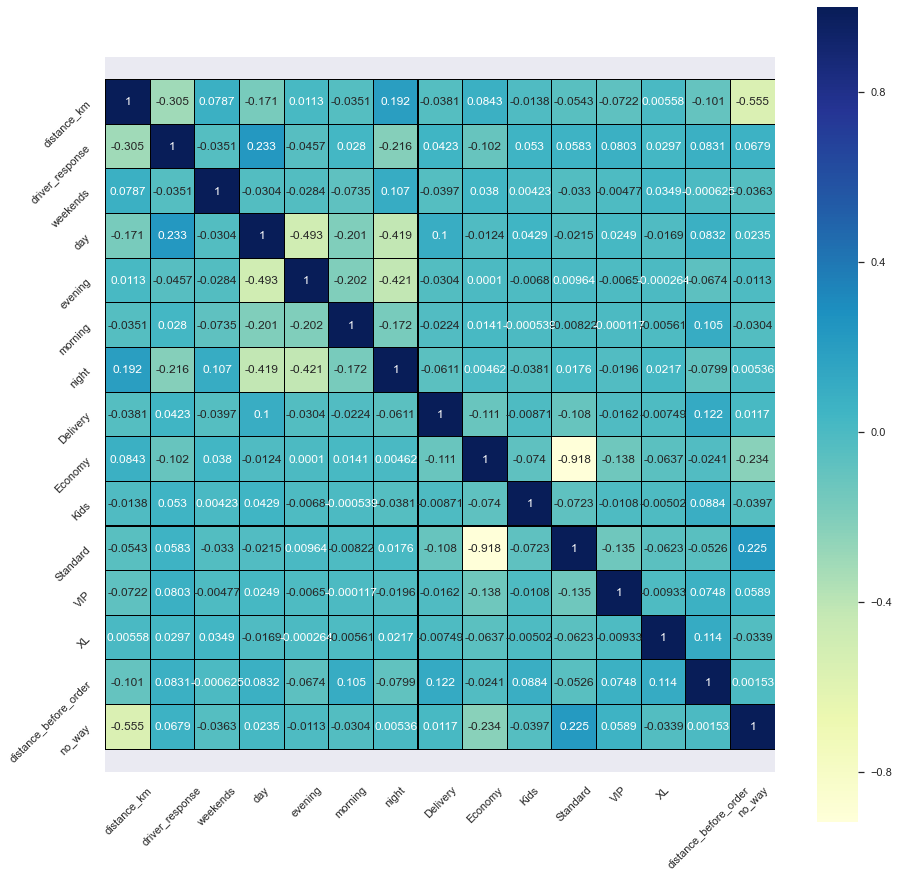

In [41]:
sns.set(rc={'figure.figsize':(15,15)})
ax = sns.heatmap(data.corr(),  
                annot = True, 
                fmt='.3g', 
                cmap= 'YlGnBu', 
                linewidths=0.1, 
                linecolor='black', 
                square=True)

plt.xticks(rotation=45)
plt.yticks(rotation=45)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

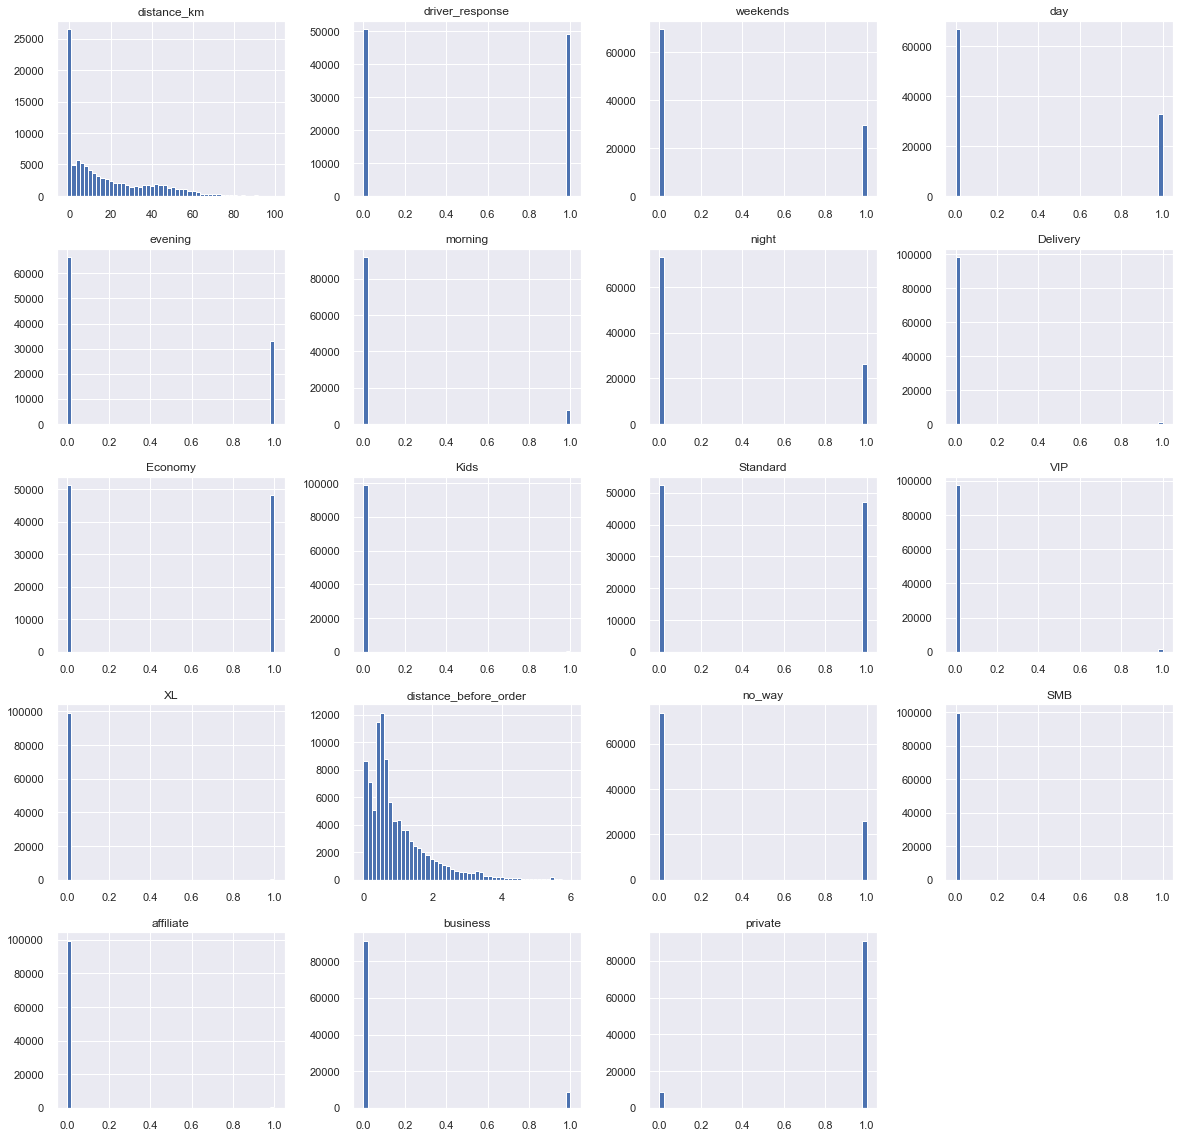

In [54]:
data.hist(figsize=(20,20), bins=50)
plt.show()

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99542 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   distance_km            99542 non-null  float64
 1   driver_response        99542 non-null  int64  
 2   weekends               99542 non-null  int32  
 3   day                    99542 non-null  uint8  
 4   evening                99542 non-null  uint8  
 5   morning                99542 non-null  uint8  
 6   night                  99542 non-null  uint8  
 7   Delivery               99542 non-null  uint8  
 8   Economy                99542 non-null  uint8  
 9   Kids                   99542 non-null  uint8  
 10  Standard               99542 non-null  uint8  
 11  VIP                    99542 non-null  uint8  
 12  XL                     99542 non-null  uint8  
 13  distance_before_order  99542 non-null  float64
 14  no_way                 99542 non-null  float64
 15  SM

##  OneHotEncoding категориальных переменных

In [56]:
X = data.drop(['driver_response'], axis = 1)
y = data['driver_response']

In [57]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)


In [58]:
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train,y_train)
model_pred = model.predict(x_test)
print('Точность модели составила (%)', 100*model.score(x_test, y_test))

Точность модели составила (%) 67.94360914844457


In [59]:
model=xgboost.XGBClassifier()
model.fit(x_train, y_train)
predicted_classes = model.predict(x_test)
accuracy = accuracy_score(y_test , predicted_classes)
print('Точность предсказания модели (%): ', accuracy*100)

Точность предсказания модели (%):  72.10929913270603


### Точность предсказания не высокая